<a href="https://colab.research.google.com/github/Kalisa21/legalEase/blob/main/legalEase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
================================================================================
LEGAL CHATBOT - PART 1: SETUP & DATA EXPLORATION
================================================================================

"""

In [1]:
# CELL 1: Install Required Packages

print(" Installing required packages...")

!pip install -q transformers
!pip install -q torch
!pip install -q sentence-transformers
!pip install -q faiss-cpu
!pip install -q datasets
!pip install -q pandas
!pip install -q numpy
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q plotly
!pip install -q wordcloud
!pip install -q tqdm

print(" All packages installed successfully!")

 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 47.4 MB/s eta 0:00:00
 All packages installed successfully!


In [2]:
# CELL 2: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import json
from collections import Counter
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print(" Libraries imported successfully!")


 Libraries imported successfully!


In [3]:
# CELL 3: Upload and Load Dataset


from google.colab import files

# Load the dataset
df = pd.read_csv('/content/penal - Sheet1.csv')

print("\n Dataset loaded successfully!")
print(f"\n Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n Columns: {list(df.columns)}")



 Dataset loaded successfully!

 Dataset Shape: 304 rows × 4 columns

 Columns: ['id', 'article_label', 'article_text', 'language']


In [4]:
# CELL 4: Initial Data Exploration

print("="*80)
print("DATASET OVERVIEW")
print("="*80)

# Basic info
print(f"\n1️ BASIC STATISTICS")
print(f"   Total Rows: {len(df)}")
print(f"   Total Columns: {len(df.columns)}")
print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Check for missing values
print(f"\n2️ DATA QUALITY")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   No missing values!")
else:
    print("    Missing values found:")
    for col, count in missing[missing > 0].items():
        print(f"      {col}: {count} ({count/len(df)*100:.2f}%)")

# Display first few rows
print(f"\n3️ SAMPLE DATA (First 3 rows)")
print(df.head(3).to_string())

# Data types
print(f"\n4️ DATA TYPES")
print(df.dtypes)


DATASET OVERVIEW

1️ BASIC STATISTICS
   Total Rows: 304
   Total Columns: 4
   Memory Usage: 191.34 KB

2️ DATA QUALITY
    Missing values found:
      id: 1 (0.33%)
      article_label: 1 (0.33%)
      article_text: 1 (0.33%)
      language: 1 (0.33%)

3️ SAMPLE DATA (First 3 rows)
    id                           article_label                                                                                                                                article_text language
0  1.0  Ingingo ya 1: Icyo iri tegeko rigamije                                         Iri tegeko riteganya: 1º amahame rusange agenga ibyaha n'ibihano; 2º ibyaha n'ibihano muri rusange.       rw
1  2.0          Article 1: Purpose of this Law                            This Law sets out: 1º general principles governing offences and penalties; 2º offences and penalties in general.       en
2  3.0     Article 1: Objet de la présente loi  La présente loi prévoit : 1º les principes généraux régissant les infractions e


LANGUAGE DISTRIBUTION ANALYSIS

 Articles per Language:
   Kinyarwanda (rw): 101 rows (33.2%)
   English (en): 101 rows (33.2%)
   French (fr): 101 rows (33.2%)

 Article Structure:
   Unique article labels: 303
   Expected unique articles: 101
   Languages per article: 1


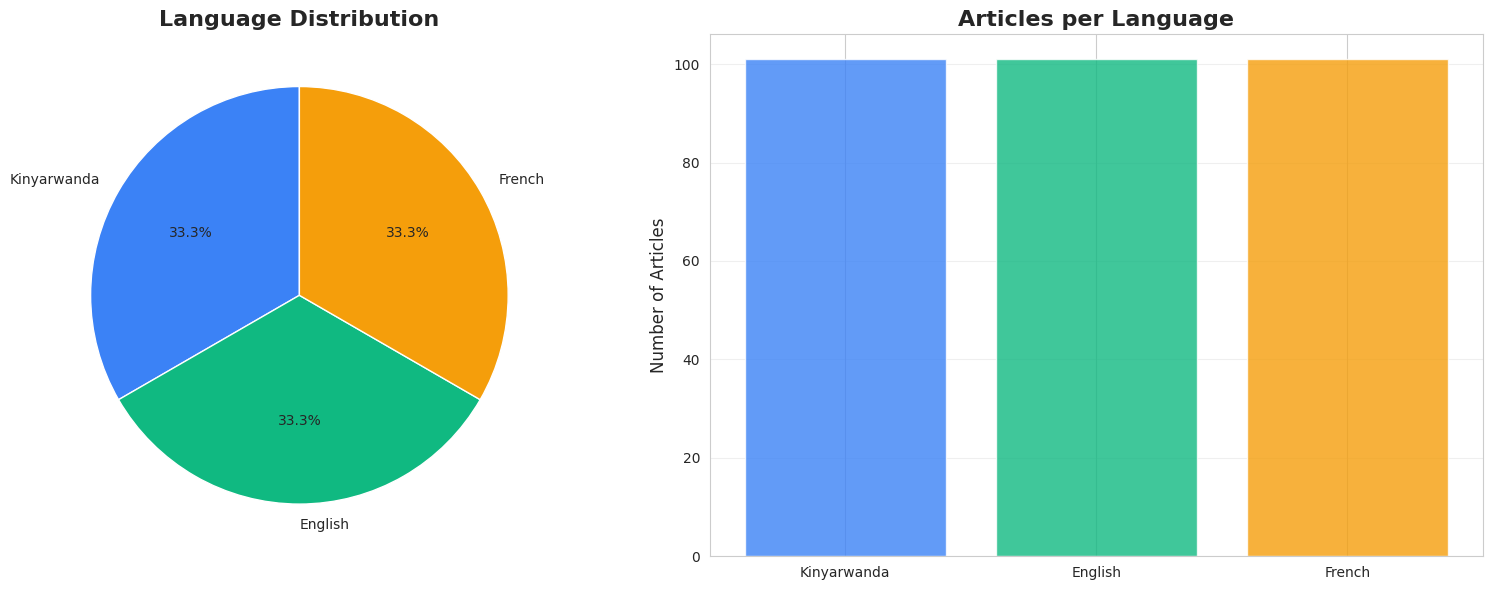


 Language analysis complete!


In [5]:
# CELL 5: Language Distribution Analysis

print("\n" + "="*80)
print("LANGUAGE DISTRIBUTION ANALYSIS")
print("="*80)

# Count by language
lang_counts = df['language'].value_counts()
print(f"\n Articles per Language:")
for lang, count in lang_counts.items():
    lang_name = {'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}.get(lang, lang)
    print(f"   {lang_name} ({lang}): {count} rows ({count/len(df)*100:.1f}%)")

# Calculate unique articles
unique_articles = df.groupby('article_label')['language'].count().value_counts()
print(f"\n Article Structure:")
print(f"   Unique article labels: {df['article_label'].nunique()}")
print(f"   Expected unique articles: {len(df) // 3}")
print(f"   Languages per article: {unique_articles.index[0] if len(unique_articles) > 0 else 'N/A'}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#3B82F6', '#10B981', '#F59E0B']
lang_names = [{'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}.get(l, l)
              for l in lang_counts.index]
ax1.pie(lang_counts.values, labels=lang_names, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Language Distribution', fontsize=16, fontweight='bold')

# Bar chart
ax2.bar(lang_names, lang_counts.values, color=colors, alpha=0.8)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Articles per Language', fontsize=16, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Language analysis complete!")

In [6]:
# CELL 6: Text Length Analysis

print("\n" + "="*80)
print("TEXT LENGTH ANALYSIS")
print("="*80)

# Calculate text lengths
df['text_length'] = df['article_text'].str.len()
df['word_count'] = df['article_text'].str.split().str.len()

# Handle potential NaN values before converting to int
df['token_estimate'] = (df['text_length'].fillna(0) / 4).astype(int)  # Rough estimate

# Statistics by language
print("\n Text Statistics by Language:\n")
stats = df.groupby('language').agg({
    'text_length': ['mean', 'min', 'max', 'std'],
    'word_count': ['mean', 'min', 'max'],
    'token_estimate': ['mean', 'min', 'max']
}).round(2)

print(stats.to_string())

# Overall statistics
print(f"\n Overall Statistics:")
print(f"   Average text length: {df['text_length'].mean():.0f} characters")
print(f"   Average word count: {df['word_count'].mean():.0f} words")
print(f"   Average tokens (estimated): {df['token_estimate'].mean():.0f} tokens")
print(f"   Shortest article: {df['text_length'].min()} characters")
print(f"   Longest article: {df['text_length'].max()} characters")

# Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Text Length Distribution', 'Text Length by Language',
                   'Word Count Distribution', 'Token Estimate by Language'),
    specs=[[{'type': 'histogram'}, {'type': 'box'}],
           [{'type': 'histogram'}, {'type': 'box'}]]
)

# Text length histogram
fig.add_trace(
    go.Histogram(x=df['text_length'], nbinsx=30, name='Text Length',
                marker_color='#3B82F6'),
    row=1, col=1
)

# Text length by language box plot
for lang in df['language'].unique():
    lang_data = df[df['language'] == lang]
    fig.add_trace(
        go.Box(y=lang_data['text_length'], name=lang,
              marker_color={'en': '#3B82F6', 'fr': '#10B981', 'rw': '#F59E0B'}.get(lang)),
        row=1, col=2
    )

# Word count histogram
fig.add_trace(
    go.Histogram(x=df['word_count'], nbinsx=30, name='Word Count',
                marker_color='#10B981'),
    row=2, col=1
)

# Token estimate by language box plot
for lang in df['language'].unique():
    lang_data = df[df['language'] == lang]
    fig.add_trace(
        go.Box(y=lang_data['token_estimate'], name=lang, showlegend=False,
              marker_color={'en': '#3B82F6', 'fr': '#10B981', 'rw': '#F59E0B'}.get(lang)),
        row=2, col=2
    )

fig.update_layout(height=800, showlegend=True, title_text="Text Length Analysis")
fig.show()

print("\n Text length analysis complete!")


TEXT LENGTH ANALYSIS

 Text Statistics by Language:

         text_length                       word_count             token_estimate         
                mean   min     max     std       mean  min    max           mean min  max
language                                                                                 
en            420.10  43.0  2667.0  407.87      69.96  8.0  412.0         104.62  10  666
fr            436.91  47.0  2585.0  395.07      69.80  9.0  429.0         108.80  11  646
rw            390.69  37.0  2301.0  351.17      51.44  5.0  289.0          97.25   9  575

 Overall Statistics:
   Average text length: 416 characters
   Average word count: 64 words
   Average tokens (estimated): 103 tokens
   Shortest article: 37.0 characters
   Longest article: 2667.0 characters



 Text length analysis complete!



WORD CLOUD GENERATION


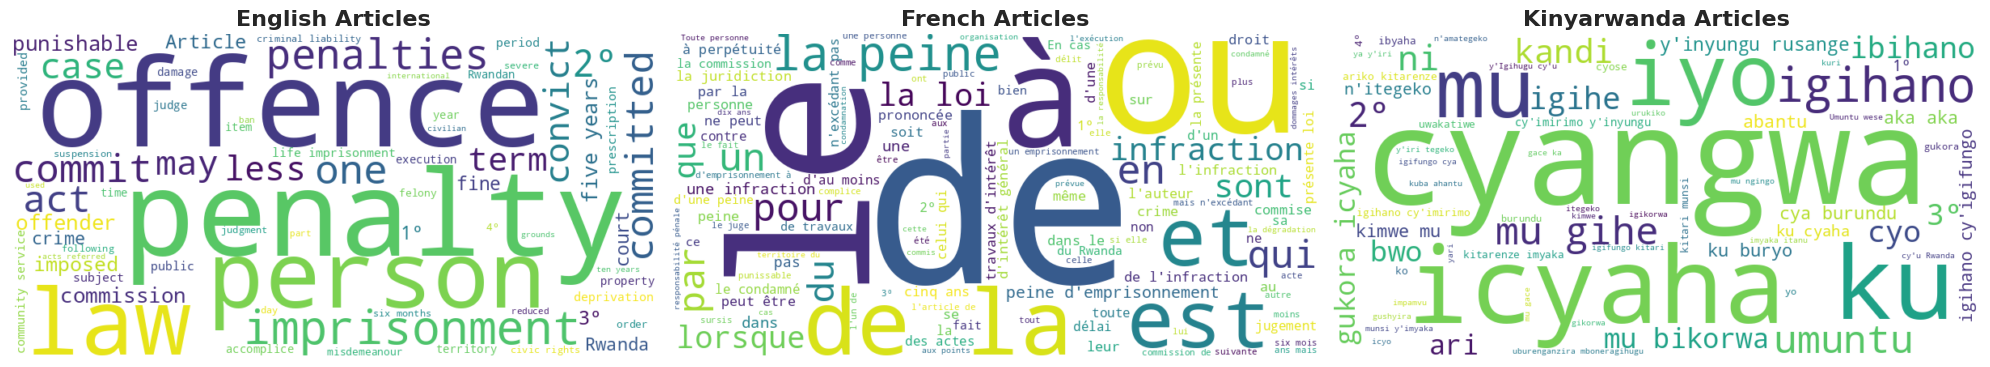


 Word clouds generated successfully!


In [10]:
# CELL 8: Generate Word Cloud
# ============================================================================
print("\n" + "="*80)
print("WORD CLOUD GENERATION")
print("="*80)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Generate word clouds for each language
languages = [('en', 'English'), ('fr', 'French'), ('rw', 'Kinyarwanda')]
fig, axes = plt.subplots(1, len(languages), figsize=(20, 6))

for idx, (lang, lang_name) in enumerate(languages):
    # Filter rows by language
    lang_df = df[df['language'] == lang]

    # Combine all article text for that language
    text = " ".join(lang_df['article_text'].dropna().astype(str))

    if text.strip():  # Only generate if not empty
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=200,
            min_font_size=10
        ).generate(text)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'{lang_name} Articles', fontsize=16, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f'No {lang_name} text', ha='center', va='center', fontsize=14)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n Word clouds generated successfully!")


In [11]:
# CELL 9: Article Structure Analysis
# ============================================================================
print("\n" + "="*80)
print("ARTICLE STRUCTURE ANALYSIS")
print("="*80)

# Analyze article numbering
df['article_number'] = df['article_label'].str.extract(r'(\d+)').astype(float)

print(f"\n Article Coverage:")
print(f"   Total unique article labels: {df['article_label'].nunique()}")
print(f"   Article numbers range: {df['article_number'].min():.0f} to {df['article_number'].max():.0f}")
print(f"   Total articles covered: {int(df['article_number'].nunique())}")

# Check for gaps in article numbering
article_numbers = sorted(df['article_number'].dropna().unique())
gaps = []
for i in range(len(article_numbers) - 1):
    if article_numbers[i+1] - article_numbers[i] > 1:
        gaps.append((int(article_numbers[i]), int(article_numbers[i+1])))

if gaps:
    print(f"\n  Gaps found in article numbering:")
    for start, end in gaps:
        print(f"   Gap between Article {start} and {end}")
else:
    print(f"\n No gaps in article numbering - consecutive coverage!")

# Distribution of articles
print(f"\n Article Distribution:")
article_dist = df.groupby('article_number').size()
print(f"   Most articles have {article_dist.mode()[0]:.0f} language versions")
print(f"   {(article_dist == 3).sum()} articles have all 3 languages")
print(f"   {(article_dist < 3).sum()} articles have incomplete translations")

# Sample article labels
print(f"\n Sample Article Labels:")
for label in df['article_label'].unique()[:10]:
    print(f"   • {label}")

print("\n Article structure analysis complete!")


ARTICLE STRUCTURE ANALYSIS

 Article Coverage:
   Total unique article labels: 303
   Article numbers range: 1 to 101
   Total articles covered: 101

 No gaps in article numbering - consecutive coverage!

 Article Distribution:
   Most articles have 3 language versions
   101 articles have all 3 languages
   0 articles have incomplete translations

 Sample Article Labels:
   • Ingingo ya 1: Icyo iri tegeko rigamije
   • Article 1: Purpose of this Law
   • Article 1: Objet de la présente loi
   • Ingingo ya 2: Ibisobanuro by'amagambo
   • Article 2: Definitions
   • Article 2: Définitions
   • Ingingo ya 3: Nta gihano hatari itegeko
   • Article 3: No punishment without law
   • Article 3: Pas de peine sans loi
   • Ingingo ya 4: Ikoreshwa ry'amategeko ahana

 Article structure analysis complete!


In [13]:
# CELL 10: Comprehensive Summary Statistics
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE DATASET SUMMARY")
print("="*80)

# Add text length and word count columns
df['text_length'] = df['article_text'].astype(str).apply(len)
df['word_count'] = df['article_text'].astype(str).apply(lambda x: len(x.split()))

summary = {
    'Total Rows': len(df),
    'Total Columns': len(df.columns),
    'Unique Articles': df['id'].nunique(),
    'Languages': len(df['language'].unique()),
    'Avg Text Length': f"{df['text_length'].mean():.0f} chars",
    'Avg Word Count': f"{df['word_count'].mean():.0f} words",
    'Data Completeness': f"{(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.1f}%",
    'Memory Usage': f"{df.memory_usage(deep=True).sum() / 1024:.2f} KB"
}

print("\n KEY STATISTICS:")
for key, value in summary.items():
    print(f"   {key:.<35} {value}")

# Save summary to file
summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
summary_df.to_csv('dataset_summary.csv', index=False)
print(f"\n Summary saved to 'dataset_summary.csv'")

print("\n" + "="*80)
print("DATA EXPLORATION COMPLETE!")
print("="*80)
print(" All visualizations and statistics have been generated.")



COMPREHENSIVE DATASET SUMMARY

 KEY STATISTICS:
   Total Rows......................... 304
   Total Columns...................... 8
   Unique Articles.................... 303
   Languages.......................... 4
   Avg Text Length.................... 415 chars
   Avg Word Count..................... 64 words
   Data Completeness.................. 99.8%
   Memory Usage....................... 200.84 KB

 Summary saved to 'dataset_summary.csv'

DATA EXPLORATION COMPLETE!
 All visualizations and statistics have been generated.


"""
================================================================================
LEGAL CHATBOT PROJECT - PART 2: DATA PROCESSING & MODEL TRAINING
================================================================================

"""

In [14]:
!pip install sentence-transformers
!pip install datasets
!pip install faiss-cpu
!pip install torch
!pip install langdetect

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, losses, models, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import faiss
import re
from typing import List, Dict, Tuple
import random
from langdetect import detect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=39d8dd60b980c8d1b055569576823c526243132f36b869828256c0710305ecd2
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [15]:
def load_dataset(file_path):
    """Load and preprocess the multilingual dataset"""
    df = pd.read_csv('/content/penal - Sheet1.csv')

    # Clean the data
    df = df.dropna(subset=['article_text'])
    df['article_text'] = df['article_text'].str.strip()

    print(f"Loaded {len(df)} total articles")
    print(f"Language distribution:")
    print(df['language'].value_counts())
    print(f"Columns: {df.columns.tolist()}")
    print("\nSample data:")
    print(df[['id', 'article_label', 'language']].head())

    return df

In [16]:
# Loading dataset
file_path = '/content/penal - Sheet1.csv'
df = load_dataset(file_path)

# Display dataset info
print(f"\nDataset shape: {df.shape}")
print(f"Unique article labels: {df['article_label'].nunique()}")

# Language detection function
def detect_query_language(query):
    """Detect the language of a user query"""
    try:
        lang = detect(query)
        return lang
    except:
        return 'en'

# Create efficient training data for fine-tuning (multilingual)

def create_training_data(df):
    """Create efficient training pairs from the multilingual legal articles"""
    training_data = []

    # Group by article ID to get multilingual versions of the same article
    article_groups = {}
    for _, row in df.iterrows():
        article_id = row['id']
        if article_id not in article_groups:
            article_groups[article_id] = []
        article_groups[article_id].append(row)

    print(f"Found {len(article_groups)} unique articles with multilingual versions")

    # Create positive pairs: same article in different languages
    for article_id, versions in article_groups.items():
        if len(versions) > 1:
            # Create pairs between different language versions of the same article
            for i in range(len(versions)):
                for j in range(i + 1, len(versions)):
                    text1 = versions[i]['article_text']
                    text2 = versions[j]['article_text']
                    lang1 = versions[i]['language']
                    lang2 = versions[j]['language']

                    training_data.append(InputExample(
                        texts=[text1, text2],
                        label=0.9
                    ))

    # Create category-based pairs within same language
    languages = df['language'].unique()
    for lang in languages:
        lang_df = df[df['language'] == lang]
        articles = lang_df['article_text'].tolist()
        article_labels = lang_df['article_label'].tolist()

        # Create category mapping
        categories = {}
        for i, (text, label) in enumerate(zip(articles, article_labels)):
            category = label.split(':')[0] if ':' in label else label
            if category not in categories:
                categories[category] = []
            categories[category].append(i)

        # Create positive pairs within same category and language
        for category, indices in categories.items():
            if len(indices) > 1:
                for i in range(min(2, len(indices))):
                    idx1 = indices[i]
                    for j in range(i + 1, min(i + 2, len(indices))):
                        idx2 = indices[j]
                        training_data.append(InputExample(
                            texts=[articles[idx1], articles[idx2]],
                            label=0.8
                        ))

        # Add hard negatives (different categories, same language)
        category_list = list(categories.keys())
        for i in range(min(100, len(articles))):
            cat1 = random.choice(category_list)
            cat2 = random.choice(category_list)
            if cat1 != cat2 and categories[cat1] and categories[cat2]:
                idx1 = random.choice(categories[cat1])
                idx2 = random.choice(categories[cat2])
                training_data.append(InputExample(
                    texts=[articles[idx1], articles[idx2]],
                    label=0.1
                ))

    # Add self-similarity examples
    for i in range(min(100, len(df))):
        idx = random.randint(0, len(df)-1)
        text = df.iloc[idx]['article_text']
        training_data.append(InputExample(
            texts=[text, text],
            label=1.0
        ))

    print(f"Created {len(training_data)} multilingual training examples")
    return training_data

Loaded 303 total articles
Language distribution:
language
rw    101
en    101
fr    101
Name: count, dtype: int64
Columns: ['id', 'article_label', 'article_text', 'language']

Sample data:
    id                           article_label language
0  1.0  Ingingo ya 1: Icyo iri tegeko rigamije       rw
1  2.0          Article 1: Purpose of this Law       en
2  3.0     Article 1: Objet de la présente loi       fr
3  4.0   Ingingo ya 2: Ibisobanuro by'amagambo       rw
4  5.0                  Article 2: Definitions       en

Dataset shape: (303, 4)
Unique article labels: 303


In [17]:
# Initialize the multilingual model
def initialize_model(model_name='intfloat/multilingual-e5-base'):
    """Initialize the multilingual Sentence Transformer model"""
    model = SentenceTransformer(model_name)
    return model

# Efficient fine-tuning for multilingual model
def fine_tune_model(model, training_data, batch_size=8, epochs=2):
    """Fine-tune the multilingual Sentence Transformer model efficiently"""

    if len(training_data) == 0:
        print("No training data available. Using base model without fine-tuning.")
        return model

    # Split training data
    train_data, eval_data = train_test_split(training_data, test_size=0.1, random_state=42)

    print(f"Training on {len(train_data)} examples, evaluating on {len(eval_data)} examples")

    # Create data loaders
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    # Define loss function
    train_loss = losses.CosineSimilarityLoss(model)

    # Calculate warmup steps
    warmup_steps = min(100, len(train_data) // batch_size)

    print("Starting fine-tuning...")

    # Fine-tune the model with simpler configuration
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=epochs,
        warmup_steps=warmup_steps,
        show_progress_bar=True,
        output_path='/content/multilingual-legal-model'
    )

    print("Fine-tuning completed!")
    return model

# Create efficient multilingual training data
print("Creating efficient multilingual training data...")
training_data = create_training_data(df)

# Initialize multilingual model
print("Initializing multilingual model...")
model = initialize_model('intfloat/multilingual-e5-base')

Creating efficient multilingual training data...
Found 303 unique articles with multilingual versions
Created 398 multilingual training examples
Initializing multilingual model...


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [ ]:
# Disable wandb logging
import os
os.environ['WANDB_DISABLED'] = 'true'

In [ ]:
# Fine-tune model
print("Fine-tuning multilingual model...")
model = fine_tune_model(model, training_data, batch_size=8, epochs=2)

# Save the fine-tuned model
model.save('/content/fine-tuned-multilingual-legal-model')
print("Model saved to /content/fine-tuned-multilingual-legal-model")

In [ ]:
# Create multilingual search index
def create_search_index(model, df):
    """Create FAISS index for efficient multilingual similarity search"""

    # Generate embeddings for all articles in all languages
    articles = df['article_text'].tolist()
    article_ids = df['id'].tolist()
    article_labels = df['article_label'].tolist()
    languages = df['language'].tolist()

    print("Generating multilingual embeddings...")
    embeddings = model.encode(articles, show_progress_bar=True, convert_to_tensor=True)

    # Convert to numpy for FAISS
    embeddings_np = embeddings.cpu().numpy()

    # Create FAISS index
    dimension = embeddings_np.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product for cosine similarity

    # Normalize vectors for cosine similarity
    faiss.normalize_L2(embeddings_np)
    index.add(embeddings_np)

    # Create mapping from index to article info
    article_info = {
        i: {
            'id': article_ids[i],
            'text': articles[i],
            'label': article_labels[i],
            'language': languages[i]
        }
        for i in range(len(articles))
    }

    return index, article_info, embeddings_np

print("Creating multilingual search index...")
index, article_info, embeddings = create_search_index(model, df)


In [ ]:
# Save the index and article info
faiss.write_index(index, '/content/multilingual_legal_articles.index')
import pickle
with open('/content/multilingual_article_info.pkl', 'wb') as f:
    pickle.dump(article_info, f)

print("Multilingual search index created and saved!")

# Multilingual Chatbot class
class MultilingualLegalArticleChatbot:
    def __init__(self, model_path, index_path, article_info_path):
        """Initialize the multilingual chatbot"""
        self.model = SentenceTransformer(model_path)
        self.index = faiss.read_index(index_path)

        with open(article_info_path, 'rb') as f:
            self.article_info = pickle.load(f)

    def preprocess_query(self, query: str) -> str:
        """Preprocess user query - no language conversion needed for multilingual model"""
        query = query.strip()

        query = re.sub(r'\s+', ' ', query)
        return query

    def detect_query_language(self, query: str) -> str:
        """Detect the language of the user query"""
        try:
            lang = detect(query)
            return lang
        except:
            return 'en'

    def search_articles(self, query: str, top_k: int = 5, target_language: str = None) -> List[Dict]:
        """Search for most relevant articles in any language"""
        # Preprocess query
        processed_query = self.preprocess_query(query)

        # Detect query language
        query_lang = self.detect_query_language(query)
        print(f"Detected query language: {query_lang}")

        # Encode query using multilingual model
        query_embedding = self.model.encode([processed_query], convert_to_tensor=True).cpu().numpy()


        faiss.normalize_L2(query_embedding)


        distances, indices = self.index.search(query_embedding, top_k * 3)

        # Prepare results
        results = []
        seen_articles = set()

        for i, (distance, idx) in enumerate(zip(distances[0], indices[0])):
            if idx in self.article_info:
                article = self.article_info[idx]
                article_id = article['id']


                if article_id in seen_articles:
                    continue

                # If target language specified, filter by language
                if target_language and article['language'] != target_language:
                    continue

                seen_articles.add(article_id)
                results.append({
                    'rank': len(results) + 1,
                    'similarity_score': float(distance),
                    'article_id': article['id'],
                    'article_label': article['label'],
                    'article_text': article['text'],
                    'language': article['language'],
                    'preview': article['text'][:200] + '...' if len(article['text']) > 200 else article['text']
                })

                # Stop when we have enough results
                if len(results) >= top_k:
                    break

        return results

    def search_by_language(self, query: str, language: str, top_k: int = 5) -> List[Dict]:
        """Search for articles in a specific language"""
        return self.search_articles(query, top_k, target_language=language)

    def get_available_languages(self) -> List[str]:
        """Get list of available languages in the dataset"""
        languages = set()
        for info in self.article_info.values():
            languages.add(info['language'])
        return sorted(list(languages))

    def format_response(self, query: str, results: List[Dict]) -> str:
        """Format the chatbot response with language information"""
        response = f"Query: '{query}'\n\n"
        response += f"Found {len(results)} relevant articles:\n\n"

        for result in results:
            response += f"{result['rank']}. {result['article_label']}\n"
            response += f"   Language: {result['language']}\n"
            response += f"   Similarity: {result['similarity_score']:.3f}\n"
            response += f"   Preview: {result['preview']}\n"
            response += f"   Article ID: {result['article_id']}\n\n"

        return response

    def chat(self):
        """Start the multilingual chatbot interface"""
        available_langs = self.get_available_languages()

        print(" Multilingual Legal Article Chatbot")
        print(f"Available languages: {', '.join(available_langs)}")
        print("You can ask questions in any language, and I'll find relevant articles.")
        print("Special commands:")
        print("  - 'lang:en' - Show only English results")
        print("  - 'lang:fr' - Show only French results")
        print("  - 'lang:rw' - Show only Kinyarwanda results")
        print("  - 'languages' - Show available languages")
        print("  - 'quit' or 'exit' - End conversation\n")

        while True:
            query = input("You: ").strip()

            if query.lower() in ['quit', 'exit', 'bye']:
                print("Goodbye! ")
                break

            if query.lower() == 'languages':
                print(f"Available languages: {', '.join(available_langs)}")
                continue

            if not query:
                print("Please enter a question.")
                continue

            # Check for language filter
            target_language = None
            if query.lower().startswith('lang:'):
                parts = query.split(':', 1)
                if len(parts) > 1:
                    target_language = parts[1].strip()
                    query = input(f"Query for {target_language} articles: ").strip()

            print("\nSearching... ")

            try:
                if target_language:
                    results = self.search_by_language(query, target_language)
                else:
                    results = self.search_articles(query)

                if results:
                    response = self.format_response(query, results)
                    print(f"\n{response}")
                else:
                    print("No relevant articles found. Try rephrasing your question or check the language filter.")

            except Exception as e:
                print(f"Error: {e}")

            print("-" * 80)


In [ ]:
# Initialize multilingual chatbot
print("Loading multilingual chatbot...")
chatbot = MultilingualLegalArticleChatbot(
    model_path='/content/fine-tuned-multilingual-legal-model',
    index_path='/content/multilingual_legal_articles.index',
    article_info_path='/content/multilingual_article_info.pkl'
)

In [ ]:
# INTENT HANDLER

class IntentHandler:
    def __init__(self):
        # Greeting patterns in all languages
        self.greeting_patterns = [
            # English
            r'\b(hello|hi|hey|good morning|good afternoon|good evening|greetings|howdy)\b',
            # French
            r'\b(bonjour|salut|bonsoir|coucou|bonjour à tous)\b',
            # Kinyarwanda
            r'\b(mwaramutse|mwirwe|muraho)\b'
        ]

        # Closing patterns in all languages
        self.closing_patterns = [
            # English
            r'\b(bye|goodbye|see you|exit|quit|farewell|see ya|good night)\b',
            # French
            r'\b(au revoir|à bientôt|adieu|salut|à plus)\b',
            # Kinyarwanda
            r'\b(murabeho|murakoze|muhaze|mwirirwe)\b'
        ]

        # Thanks patterns
        self.thanks_patterns = [
            r'\b(thanks|thank you|thankyou|thx|merci|gracias|murakoze)\b'
        ]

        self.legal_similarity_threshold = 0.35

    def is_greeting(self, query):
        """Check if query is a greeting"""
        query_lower = query.lower()
        for pattern in self.greeting_patterns:
            if re.search(pattern, query_lower, re.IGNORECASE):
                return True
        return False

    def is_closing(self, query):
        """Check if query is a closing"""
        query_lower = query.lower()
        for pattern in self.closing_patterns:
            if re.search(pattern, query_lower, re.IGNORECASE):
                return True
        return False

    def is_thanks(self, query):
        """Check if query is thanks"""
        query_lower = query.lower()
        for pattern in self.thanks_patterns:
            if re.search(pattern, query_lower, re.IGNORECASE):
                return True
        return False

    def get_greeting_response(self):
        """Return greeting response"""
        return """Hello!  I'm your legal assistant specializing in Rwandan law.
I can help you search articles in English, French, or Kinyarwanda.

What legal topic can I help you with today?"""

    def get_closing_response(self):
        """Return closing response"""
        return "Goodbye!  Feel free to return if you have more legal questions."

    def get_thanks_response(self):
        """Return thanks response"""
        return "You're welcome! Let me know if you need help with other legal articles."

    def get_out_of_domain_response(self):
        """Return out-of-domain response"""
        return """I specialize in Rwandan legal articles and penal code information.
I can help you with topics like offences, penalties, legal definitions, and criminal procedures.

Try questions like:
• 'What is the definition of an offence?'
• 'Tell me about penalties for crimes'
• 'Explain criminal liability'
• 'What constitutes genocide?'"""


In [ ]:
# ENHANCED CHATBOT WITH INTENT HANDLING

class EnhancedMultilingualLegalArticleChatbot(MultilingualLegalArticleChatbot):
    def __init__(self, model_path, index_path, article_info_path):
        """Initialize enhanced chatbot with intent handling"""
        super().__init__(model_path, index_path, article_info_path)
        self.intent_handler = IntentHandler()

    def classify_intent(self, query):
        """Classify user intent"""
        # Check for greetings, closings, thanks first
        if self.intent_handler.is_greeting(query):
            return "greeting"
        if self.intent_handler.is_closing(query):
            return "closing"
        if self.intent_handler.is_thanks(query):
            return "thanks"

        # For other queries, check if they're legal-related
        try:
            results = self.search_articles(query, top_k=1)
            if results and results[0]['similarity_score'] >= self.intent_handler.legal_similarity_threshold:
                return "legal_query"
            else:
                return "out_of_domain"
        except:
            return "out_of_domain"

    def handle_intent(self, query, intent):
        """Handle different intents with appropriate responses"""
        if intent == "greeting":
            return self.intent_handler.get_greeting_response(), None

        elif intent == "closing":
            return self.intent_handler.get_closing_response(), None

        elif intent == "thanks":
            return self.intent_handler.get_thanks_response(), None

        elif intent == "out_of_domain":
            return self.intent_handler.get_out_of_domain_response(), None

        else:  # legal_query
            results = self.search_articles(query)
            if results:
                response = self.format_response(query, results)
                return response, results
            else:
                return "No relevant legal articles found. Try rephrasing your question.", None

    def enhanced_chat(self):
        """Start enhanced chatbot with intent handling"""
        available_langs = self.get_available_languages()

        print(" Enhanced Multilingual Legal Article Chatbot")
        print(f"Available languages: {', '.join(available_langs)}")
        print("I can handle greetings, legal questions, and more!")
        print("Special commands:")
        print("  - 'lang:en' - Show only English results")
        print("  - 'lang:fr' - Show only French results")
        print("  - 'lang:rw' - Show only Kinyarwanda results")
        print("  - 'languages' - Show available languages")
        print("  - 'quit' or 'exit' - End conversation\n")

        while True:
            query = input("You: ").strip()

            if query.lower() in ['quit', 'exit', 'bye']:
                print(self.intent_handler.get_closing_response())
                break

            if query.lower() == 'languages':
                print(f"Available languages: {', '.join(available_langs)}")
                continue

            if not query:
                print("Please enter a question.")
                continue

            # Check for language filter
            target_language = None
            if query.lower().startswith('lang:'):
                parts = query.split(':', 1)
                if len(parts) > 1:
                    target_language = parts[1].strip()
                    query = input(f"Query for {target_language} articles: ").strip()

            print("\nAnalyzing your query... ")

            try:
                # Classify intent
                intent = self.classify_intent(query)
                print(f"Detected intent: {intent}")

                # Handle intent
                response, results = self.handle_intent(query, intent)
                print(f"\n{response}")

            except Exception as e:
                print(f"Error: {e}")

            print("-" * 80)

In [18]:
# Initialize  chatbot
print("Loading enhanced chatbot with intent handling...")
enhanced_chatbot = EnhancedMultilingualLegalArticleChatbot(
    model_path='/content/drive/MyDrive/legalEase/fine-tuned-multilingual-legal-model',
    index_path='/content/drive/MyDrive/legalEase/multilingual_legal_articles.index',
    article_info_path='/content/drive/MyDrive/legalEase/multilingual_article_info.pkl'
)

# Test intent classification
def test_intent_classification():
    """Test the intent classification system"""
    test_queries = [
        ("Hello there!", "greeting"),
        ("Bonjour!", "greeting"),
        ("Mwaramutse", "greeting"),
        ("Goodbye everyone", "closing"),
        ("Au revoir", "closing"),
        ("Murabeho", "closing"),
        ("Thank you!", "thanks"),
        ("Merci beaucoup", "thanks"),
        ("What is an offence?", "legal_query"),
        ("Qu'est-ce qu'une infraction?", "legal_query"),
        ("What's the weather like?", "out_of_domain"),
        ("Tell me about sports", "out_of_domain")
    ]

    print(" Testing Intent Classification\n")

    for query, expected_intent in test_queries:
        detected_intent = enhanced_chatbot.classify_intent(query)
        status = "" if detected_intent == expected_intent else ""
        print(f"{status} '{query}' -> Expected: {expected_intent}, Got: {detected_intent}")

# Run intent tests
test_intent_classification()

# Start enhanced interactive chat
print("\n" + "="*80)
print("STARTING ENHANCED MULTILINGUAL INTERACTIVE CHAT")
print("="*80)
enhanced_chatbot.enhanced_chat()

Loading enhanced chatbot with intent handling...


NameError: name 'EnhancedMultilingualLegalArticleChatbot' is not defined